In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

## Load dataset

In [ ]:
# --------------------------
# 1. Data Loading
# --------------------------
# MNIST is 28x28 grayscale. We'll keep it at 28x28 here, even though ResNet
# was originally trained on 224x224 color images.
# (You could also upsample to 224 if you prefer.)
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalization values below are arbitrary placeholders for MNIST;
    # in practice you might fine-tune these.
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

## Load Pretrained ResNet


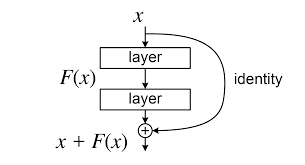


Plain CNN block:
x → conv → conv → output

ResNet block:
x → conv → conv → output + x

In [ ]:
# --------------------------
# 2. Load Pretrained ResNet
# --------------------------
# We'll use ResNet18 as an example.
# More pretrained models can be found here: https://pytorch.org/vision/0.20/models.html
model = models.resnet18(pretrained=True)

print("Before change: First layer (conv)", model.conv1)

print("Before change: Last layer (FC)", model.fc)
# --------------------------
# 3. Modify the Network
# --------------------------
# (A) Replace the first conv layer to accept 1-channel input
# Note: The original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
# We create a new Conv2d that takes 1 input channel instead of 3.
model.conv1 = nn.Conv2d(
    1, 64, kernel_size=7, stride=2, padding=3, bias=False
)


# (B) Replace final FC layer with output size of 10 classes
# ResNet18’s fc layer has in_features=512. We set out_features=10 for MNIST.
model.fc = nn.Linear(in_features=512, out_features=10)

print("After change: First layer (conv)", model.conv1)

print("After change: Last layer (FC)", model.fc)


In [6]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


    def forward(self, x):

        identity = x    
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
    
        out = self.conv2(out)
        out = self.bn2(out)
    
        # if shape changed (channels or stride), use downsample on the skip
        if self.downsample is not None:
            identity = self.downsample(x)
    
        out = out + identity      # <-- THIS is where residual happens
        out = self.relu(out)
    
        return out

In [ ]:
# --------------------------
# 4. Move to GPU (if available)
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------
# 5. Define Loss and Optimizer
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Freeze major parts of pre-trained weights

In [18]:
num_parameters = 0
for param in model.parameters():
    num_parameters += len(param)

print(num_parameters)

14420


In [19]:
num_parameters = 0
for layer in [model.conv1, model.fc]:
    num_parameters += len(layer.weight)

print(num_parameters)

74


In [20]:
# --------------------------
# 6. Freeze major parts of pre-trained weights
# --------------------------

# Freeze all parameters first, then unfreeze parts later
for param in model.parameters():
    param.requires_grad = False

# Unfreeze just the first layer:
for param in model.conv1.parameters():
    param.requires_grad = True

# Unfreeze the final layer:
for param in model.fc.parameters():
    param.requires_grad = True

## Define helper function to evaluate model

In [21]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

In [23]:
# --------------------------
# 7. Training Loop
# --------------------------


num_epochs = 5

# Compute accuracy for model that is NOT fine-tuned yet
train_accuracy = evaluate_model(model, train_loader)
test_accuracy = evaluate_model(model, test_loader)
print(f"Epoch [{0}/{num_epochs}], Loss: [Not fine-tuned yet], Train Accuracy: {test_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average training loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = evaluate_model(model, train_loader)
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Epoch [0/5], Loss: [Not fine-tuned yet], Train Accuracy: 91.58%, Test Accuracy: 91.58%
Epoch [1/5], Loss: 0.3178, Train Accuracy: 92.47%, Test Accuracy: 92.08%
Epoch [2/5], Loss: 0.3064, Train Accuracy: 92.53%, Test Accuracy: 91.91%
Epoch [3/5], Loss: 0.2953, Train Accuracy: 92.78%, Test Accuracy: 92.29%
Epoch [4/5], Loss: 0.2909, Train Accuracy: 92.86%, Test Accuracy: 92.33%
Epoch [5/5], Loss: 0.2833, Train Accuracy: 93.42%, Test Accuracy: 92.88%
